Cleaned version with only final codes used to perform statical analysis and build the presentation. Current heuristcs were tunned for high volatility stocks such as TSLA and AMZN, with reasonably high betas

Code 1: Algorithm to obtain results for 1 simulation with AI agents

[*********************100%%**********************]  1 of 1 completed


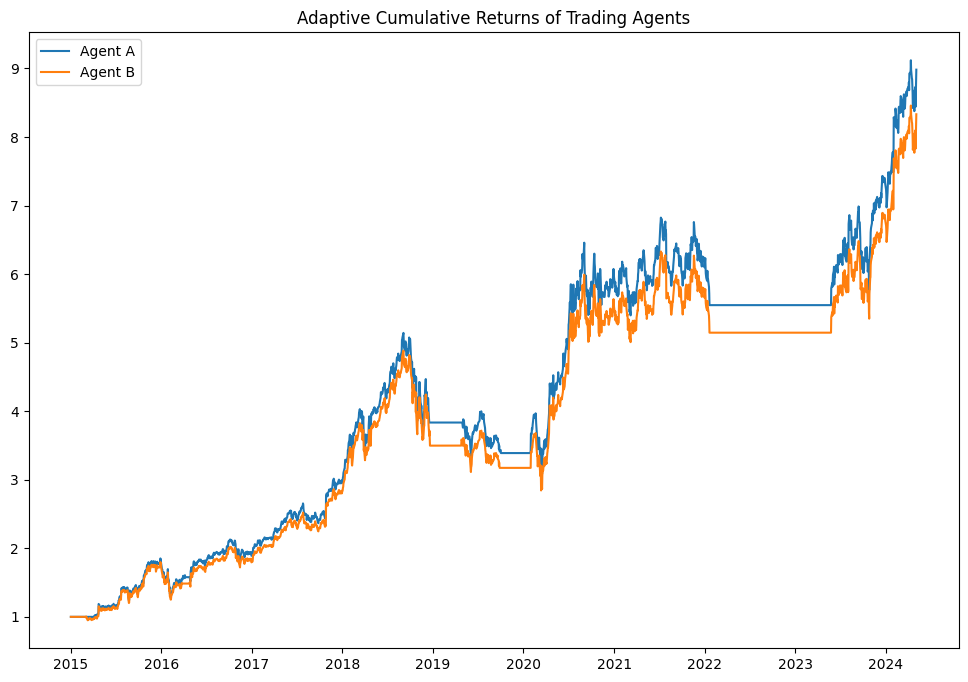

Final Cumulative Returns - AMZN
Original Agent A: 7.864900451883507
Original Agent B: 7.761582477240922
Adaptive Agent A: 8.98249282716534
Adaptive Agent B: 8.331774799957556
Final windows for Agent A: {'short_window': 48, 'long_window': 242}
Final windows for Agent B: {'short_window': 42, 'long_window': 240}


In [8]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import random

def hVol(data):
    log_returns = np.log(data['Close'] / data['Close'].shift(1))
    return log_returns.std() * np.sqrt(252)

# Define the ticker symbol and time window
ticker = "AMZN"
startD = "2015-01-01"

# Get historical market data for the ticker symbol
stock_data = yf.download(ticker, start=startD)

# Initialize agents with different windows

agents = {
    'A': {'short_window': 60, 'long_window': 240},
    'B': {'short_window': 40, 'long_window': 160}
}


def adjust_windows(winner, loser):
    for key in ['short_window', 'long_window']:
        if agents[winner][key] > agents[loser][key]:
            agents[loser][key] += round(agents[loser][key]/5)
        elif agents[winner][key] < agents[loser][key]:
            agents[loser][key] -= round(agents[loser][key]/5)
        else:
            # If the window sizes are the same, randomly increase or decrease by 20%
            if random.choice([True, False]):  # Randomly choose True or False
                agents[loser][key] += max(round(agents[loser][key] * 0.03),1)  #3% change
            else:
                agents[loser][key] -= max(round(agents[loser][key] * 0.03),1)

        if key ==  'short_window' and agents[loser][key] < 35:
            agents[loser][key] = 35
        if key ==  'short_window' and agents[loser][key] > 65:
            agents[loser][key] = 65

        if key == 'long_window' and agents[loser][key] < 140:
            agents[loser][key] = 140
        if key == 'long_window' and agents[loser][key] > 260:
            agents[loser][key] = 260

def calculate_strategies(start, end, results):
    for agent in agents:
        short_w = agents[agent]['short_window']
        long_w = agents[agent]['long_window']

        # Calculate SMAs using the entire dataset
        sma_short = stock_data['Close'].rolling(window=short_w, min_periods=1).mean()
        sma_long = stock_data['Close'].rolling(window=long_w, min_periods=1).mean()
        signals = np.where(sma_short.iloc[start:end+1] > sma_long.iloc[start:end+1], 1.0, 0.0)

        # Handle returns calculation to include the previous closing for accurate return calculation
        if start == 0:
            returns = stock_data['Close'].iloc[start:end+1].pct_change()
            strategy_returns = signals[1:] * returns.values[1:]  # Skip the first NaN
        else:
            returns = stock_data['Close'].iloc[start-1:end+1].pct_change()
            strategy_returns = signals[0:] * returns.values[1:]

        if start == 0:
            cumulative_returns = np.insert((1 + strategy_returns).cumprod(), 0, 1)
        else:
            previous_cumulative = results[agent][-1]
            cumulative_returns = (1 + strategy_returns).cumprod() * previous_cumulative

        results[agent].extend(cumulative_returns.tolist())

# Store results in a dictionary
results = {'A': [], 'B': []}
original_results = {'A': [], 'B': []}

segment_length = 10  # Use a larger segment length if possible to ensure SMAs can be calculated

delta = len(stock_data)-round(len(stock_data)/segment_length)*segment_length

# Calculate original strategies without adjustment
calculate_strategies(0, len(stock_data) - 1-delta, original_results)

start = 0

while start + segment_length <= len(stock_data):
    end = start + segment_length - 1
    calculate_strategies(start, end, results)

    if not np.isnan(results['A'][-1]) and not np.isnan(results['B'][-1]):
        cumulative_A = results['A'][-1]
        cumulative_B = results['B'][-1]
        if start > 0:
            cumulative_A = results['A'][-1]/results['A'][-segment_length]
            cumulative_B = results['B'][-1]/results['B'][-segment_length]

        if cumulative_A > cumulative_B:
            adjust_windows('A', 'B')
        elif cumulative_A < cumulative_B:
            adjust_windows('B', 'A')



    start = end + 1

# Create date ranges for plotting
dates = stock_data.index[:len(results['A'])]

# Plot the cumulative returns for both agents
plt.figure(figsize=(12, 8))
plt.plot(dates, results['A'], label='Agent A')
plt.plot(dates, results['B'], label='Agent B')
plt.legend()
plt.title("Adaptive Cumulative Returns of Trading Agents")
plt.show()

# Print final cumulative returns and final windows
print('Final Cumulative Returns -', ticker)
print('Original Agent A:', original_results['A'][-1])
print('Original Agent B:', original_results['B'][-1])
print('Adaptive Agent A:', results['A'][-1])
print('Adaptive Agent B:', results['B'][-1])
print('Final windows for Agent A:', agents['A'])
print('Final windows for Agent B:', agents['B'])

Code 2: Algorithm running 50 simulations for hypohotesis testing

In [9]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import random


# Choose the tickerand time window
ticker = "AMZN"
startD = "2015-01-01"

# Get historical market data for that ticker (Yahoo)
stock_data = yf.download(ticker, start=startD)


final_results_A = []
final_results_B = []


for i in range(50):

    # Initialize agents with different windows
    agents = {
        'A': {'short_window': 60, 'long_window': 240},
        'B': {'short_window': 40, 'long_window': 160}
    }

    def adjust_windows(winner, loser):
      for key in ['short_window', 'long_window']:
          if agents[winner][key] > agents[loser][key]:
              agents[loser][key] += round(agents[loser][key]/5)
          elif agents[winner][key] < agents[loser][key]:
              agents[loser][key] -= round(agents[loser][key]/5)
          else:
              # If the window sizes are the same, randomly increase or decrease by 20%
              if random.choice([True, False]):  # Randomly choose True or False
                  agents[loser][key] += max(round(agents[loser][key] * 0.03),1)  #3% change
              else:
                  agents[loser][key] -= max(round(agents[loser][key] * 0.03),1)

          if key ==  'short_window' and agents[loser][key] < 35:
              agents[loser][key] = 35
          if key ==  'short_window' and agents[loser][key] > 65:
              agents[loser][key] = 65

          if key == 'long_window' and agents[loser][key] < 140:
              agents[loser][key] = 140
          if key == 'long_window' and agents[loser][key] > 260:
              agents[loser][key] = 260



    def calculate_strategies(start, end, results):
        for agent in agents:
            short_w = agents[agent]['short_window']
            long_w = agents[agent]['long_window']

            # Calculate Moving Averages using the entire dataset
            sma_short = stock_data['Close'].rolling(window=short_w, min_periods=1).mean()
            sma_long = stock_data['Close'].rolling(window=long_w, min_periods=1).mean()

            # Stabilish Hold or exit signals
            signals = np.where(sma_short.iloc[start:end+1] > sma_long.iloc[start:end+1], 1.0, 0.0)

            # Handle returns calculation to include the previous closing for accurate return calculation
            if start == 0:
                returns = stock_data['Close'].iloc[start:end+1].pct_change()
                strategy_returns = signals[1:] * returns.values[1:]  # Skip the first NaN
            else:
                returns = stock_data['Close'].iloc[start-1:end+1].pct_change()
                strategy_returns = signals[0:] * returns.values[1:]

            if start == 0:
                cumulative_returns = np.insert((1 + strategy_returns).cumprod(), 0, 1)
            else:
                previous_cumulative = results[agent][-1]
                cumulative_returns = (1 + strategy_returns).cumprod() * previous_cumulative

            results[agent].extend(cumulative_returns.tolist())

    # We store results in a dictionary
    results = {'A': [], 'B': []}
    original_results = {'A': [], 'B': []}

    segment_length = 10  # Duration of each round

    delta = len(stock_data)-round(len(stock_data)/segment_length)*segment_length

    # Then we calculate original strategies without adjustment
    calculate_strategies(0, len(stock_data) - 1-delta, original_results)


    start = 0

    while start + segment_length <= len(stock_data):
        end = start + segment_length - 1
        calculate_strategies(start, end, results)

        if not np.isnan(results['A'][-1]) and not np.isnan(results['B'][-1]):
            cumulative_A = results['A'][-1]
            cumulative_B = results['B'][-1]
            if start > 0:
                cumulative_A = results['A'][-1]/results['A'][-segment_length]
                cumulative_B = results['B'][-1]/results['B'][-segment_length]

            if cumulative_A > cumulative_B:
                adjust_windows('A', 'B')
            elif cumulative_A < cumulative_B:
                adjust_windows('B', 'A')



        start = end + 1

    # Create date ranges for plotting
    dates = stock_data.index[:len(results['A'])]

    final_results_A.append(results['A'][-1])
    final_results_B.append(results['B'][-1])


print('Original Agent A:', original_results['A'][-1])
print('Original Agent B:', original_results['B'][-1])
print("Final Results for Agent A over 50 simulations:", final_results_A)
print("Final Results for Agent B over 50 simulations:", final_results_B)

[*********************100%%**********************]  1 of 1 completed


Original Agent A: 7.864900451883507
Original Agent B: 7.761582477240922
Final Results for Agent A over 50 simulations: [10.864705652506341, 8.85969553763876, 8.801123932443344, 9.144681641857542, 8.892502881276354, 9.537253165900841, 7.726142968841919, 10.899731297310778, 9.029795052801804, 8.016075370748508, 10.265446589142101, 9.313286797048017, 10.16794201822897, 7.61241726120455, 10.799613840945897, 7.486846693610289, 7.7765368248308295, 11.621322854197317, 8.833227985622916, 8.634867438626072, 8.367113951806703, 9.132146066730062, 8.995184422023387, 8.54656735027549, 7.030749170139997, 8.80285084141321, 9.13263000037631, 8.057982830135797, 9.693635877370125, 10.824490469425704, 9.472342825873188, 9.46894733276192, 7.8240514537214025, 8.970764781386482, 10.219617721511671, 10.577883116551462, 9.083953596518098, 7.133088989777066, 11.950491496785764, 9.406637281663555, 10.598921413372297, 8.680846881436082, 10.190881609205418, 10.302567090567385, 7.975885563654218, 8.122469195002576